# Leccion 1

- **Interoperabilidad:** conectar múltiples sistemas heterogéneos (bases de datos, APIs, sensores, hojas de cálculo, etc.).
- **Unificación semántica:** transformar y estandarizar datos para que sean coherentes entre sistemas.
- **Orquestación:** controlar el flujo, el orden y la lógica de procesamiento entre distintas fuentes y destinos.
- **Escalabilidad:** permitir crecimiento en volumen de datos y cantidad de sistemas conectados sin rediseñar toda la arquitectura.
- **Trazabilidad:** registrar el recorrido y las transformaciones de los datos (linaje).

---

## Tipos de integración aplicables

La empresa de logística inteligente necesita integrar datos de operaciones, IoT y reportes.  
Se recomienda usar una **estrategia híbrida** que combine los tres tipos de integración:

| Tipo de integración | Cómo funciona | Aplicación en este caso |
|---------------------|---------------|--------------------------|
| **Consolidación** | Extrae datos de múltiples sistemas, los transforma y los almacena en un repositorio central (ETL). | Consolidar reportes históricos y KPIs operativos en un Data Warehouse. |
| **Virtualización** | Crea una capa lógica que permite consultar múltiples fuentes como si fueran una sola, sin mover los datos. | Consultar en tiempo real sensores IoT, CRM y ERP sin duplicar información. |
| **Replicación** | Copia continuamente los cambios de un sistema origen a un destino. | Mantener sincronizadas bases operativas y analíticas, por ejemplo replicar eventos IoT hacia un lago de datos. |

**Conclusión:** Una arquitectura híbrida permite responder tanto a necesidades históricas (batch) como en tiempo real (streaming).

##  Mapa conceptual del flujo general

```mermaid
graph TD
    A[Fuentes de datos<br>(CSV / IoT / DB)] --> B[Apache NiFi<br>Orquestación y ETL]
    B --> C1[Procesamiento en streaming<br>Kafka + NiFi]
    B --> C2[Ingesta batch<br>NiFi + DB]
    C1 --> D[Data Lake / Data Warehouse]
    C2 --> D
    D --> E[Dashboards / BI<br>(Power BI / Grafana)]

##  Justificación de la arquitectura propuesta

La arquitectura propuesta responde a los principales problemas detectados en la organización:

- **Los sistemas están aislados y no pueden compartir datos entre sí.**  
  → Se propone usar **Apache NiFi** para conectar múltiples fuentes y destinos con **bajo acoplamiento**.

- **Existe duplicidad de datos entre plataformas.**  
  → Se aplicarán **transformaciones estandarizadas** y **deduplicación** durante la ingesta.

- **Los reportes tardan demasiado en generarse y llegan desactualizados.**  
  → Se usará **batch ETL programado** para consolidar datos históricos y **streaming en tiempo real** para procesar eventos IoT.

- **Hay falta de trazabilidad sobre el recorrido de los datos.**  
  → Se utilizará el módulo de **Provenance Tracking de NiFi** para registrar cada paso del flujo de datos.

- **La arquitectura actual no escala fácilmente.**  
  → Se propone una arquitectura **modular y distribuida** que permite añadir nuevas fuentes (sensores, APIs, bases de datos) sin necesidad de rediseñar toda la solución.

Con estas medidas se logrará una **visión única, confiable y en tiempo real** de las operaciones logísticas


# Leccion 2

In [38]:
from pathlib import Path
import pandas as pd
from datetime import date
from IPython.display import Image, display

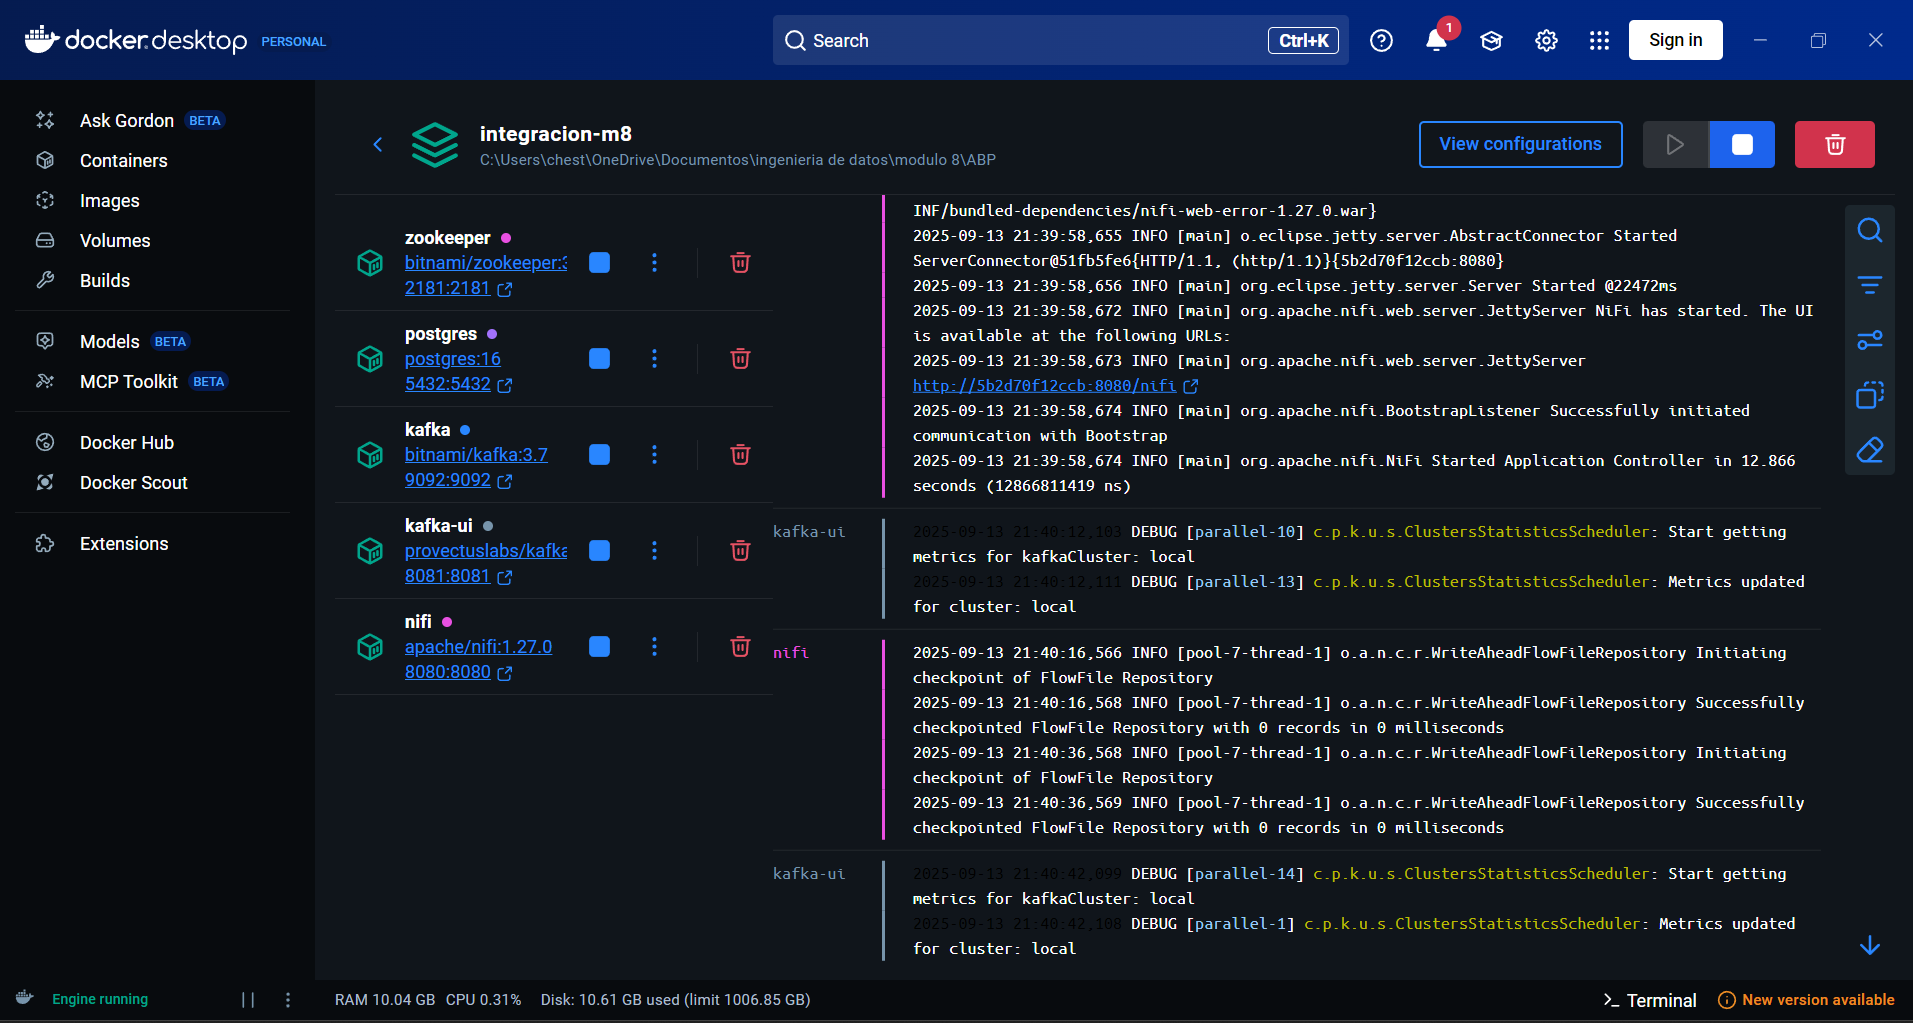

In [39]:
#imagen de docker funcionando
display(Image(filename="cap01.png"))

In [15]:
BASE = Path.cwd() / "data"  
IN_DIR = BASE / "in"
ERROR_DIR = BASE / "errors"
PROCESADOS_DIR = BASE / "processed"
OUT_DIR = BASE / "out"

for p in [IN_DIR, ERROR_DIR, PROCESADOS_DIR, OUT_DIR]:
    p.mkdir(parents=True, exist_ok=True)

df = pd.DataFrame({
    "id_envio": [1001,1002,1003,1004],
    "fecha": [str(date.today())]*4,
    "origen": ["Santiago","Santiago","Valparaíso","Temuco"],
    "destino": ["Valparaíso","Concepción","Temuco","Santiago"],
    "estado": ["Entregado","En tránsito","Demorado","Entregado"]
})
csv_path = IN_DIR / "operaciones.csv"
df.to_csv(csv_path, index=False)
csv_path, df.head()

(WindowsPath('C:/Users/chest/OneDrive/Documentos/ingenieria de datos/modulo 8/data/in/operaciones.csv'),
    id_envio       fecha      origen     destino       estado
 0      1001  2025-09-13    Santiago  Valparaíso    Entregado
 1      1002  2025-09-13    Santiago  Concepción  En tránsito
 2      1003  2025-09-13  Valparaíso      Temuco     Demorado
 3      1004  2025-09-13      Temuco    Santiago    Entregado)

In [16]:
from sqlalchemy import create_engine, text

# Credenciales del Postgres del compose
PG_USER = "admin"
PG_PASS = "admin"
PG_DB   = "demo"
PG_HOST = "localhost"
PG_PORT = 5432

engine = create_engine(f"postgresql+psycopg2://{PG_USER}:{PG_PASS}@{PG_HOST}:{PG_PORT}/{PG_DB}", future=True)

ddl = """
CREATE TABLE IF NOT EXISTS envios (
  id_envio    INTEGER PRIMARY KEY,
  fecha       DATE NOT NULL,
  origen      VARCHAR(100) NOT NULL,
  destino     VARCHAR(100) NOT NULL,
  estado      VARCHAR(30)  NOT NULL
);
"""
with engine.begin() as conn:
    conn.execute(text(ddl))

print("Tabla 'envios' lista.")

Tabla 'envios' lista.


In [19]:
# Cargar el CSV directamente (prueba de conectividad con Postgres)

df = pd.read_csv(csv_path)

# Vaciar tabla antes de insertar
with engine.begin() as conn:
    conn.execute(text("TRUNCATE TABLE envios;"))

# Insertar todos los registros desde cero
df.to_sql("envios", engine, if_exists="append", index=False)

print(f"Tabla vaciada e insertados {len(df)} registros correctamente.")

Tabla vaciada e insertados 4 registros correctamente.


In [20]:
with engine.begin() as conn:
    res = conn.execute(text("SELECT * FROM envios ORDER BY id_envio LIMIT 20;"))
    df_res = pd.DataFrame(res.fetchall(), columns=res.keys())
df_res

,id_envio,fecha,origen,destino,estado
0,1001,2025-09-13,Santiago,Valparaíso,Entregado
1,1002,2025-09-13,Santiago,Concepción,En tránsito
2,1003,2025-09-13,Valparaíso,Temuco,Demorado
3,1004,2025-09-13,Temuco,Santiago,Entregado


In [23]:
from kafka import KafkaProducer
import json, time, random

producer = KafkaProducer(
    bootstrap_servers='localhost:9092',
    value_serializer=lambda v: json.dumps(v).encode('utf-8')
)

topic = "eventos"
print(f"Enviando a topic: {topic} (Ctrl+C para detener)")

for i in range(10):
    msg = {
        "id": i,
        "tipo": random.choice(["INFO","ALERTA","ERROR"]),
        "valor": random.randint(1,1000)
    }
    producer.send(topic, msg)
    producer.flush()
    print("→", msg)
    time.sleep(0.5)

print("Listo.")

Enviando a topic: eventos (Ctrl+C para detener)
→ {'id': 0, 'tipo': 'ERROR', 'valor': 618}
→ {'id': 1, 'tipo': 'ALERTA', 'valor': 169}
→ {'id': 2, 'tipo': 'ALERTA', 'valor': 523}
→ {'id': 3, 'tipo': 'INFO', 'valor': 349}
→ {'id': 4, 'tipo': 'ERROR', 'valor': 678}
→ {'id': 5, 'tipo': 'ALERTA', 'valor': 154}
→ {'id': 6, 'tipo': 'ALERTA', 'valor': 549}
→ {'id': 7, 'tipo': 'ALERTA', 'valor': 241}
→ {'id': 8, 'tipo': 'ERROR', 'valor': 365}
→ {'id': 9, 'tipo': 'ERROR', 'valor': 780}
Listo.


In [24]:
from kafka import KafkaConsumer
import json

consumer = KafkaConsumer(
    'eventos',
    bootstrap_servers='localhost:9092',
    auto_offset_reset='earliest',
    enable_auto_commit=True,
    group_id='demo-jupyter',
    value_deserializer=lambda m: json.loads(m.decode('utf-8'))
)

print("Escuchando 'eventos' (primeros 10 mensajes):")
count = 0
for msg in consumer:
    print("←", msg.value)
    count += 1
    if count >= 10:
        break

Escuchando 'eventos' (primeros 10 mensajes):
← {'id': 0, 'tipo': 'ERROR', 'valor': 618}
← {'id': 1, 'tipo': 'ALERTA', 'valor': 169}
← {'id': 2, 'tipo': 'ALERTA', 'valor': 523}
← {'id': 3, 'tipo': 'INFO', 'valor': 349}
← {'id': 4, 'tipo': 'ERROR', 'valor': 678}
← {'id': 5, 'tipo': 'ALERTA', 'valor': 154}
← {'id': 6, 'tipo': 'ALERTA', 'valor': 549}
← {'id': 7, 'tipo': 'ALERTA', 'valor': 241}
← {'id': 8, 'tipo': 'ERROR', 'valor': 365}
← {'id': 9, 'tipo': 'ERROR', 'valor': 780}


# Leccion 3

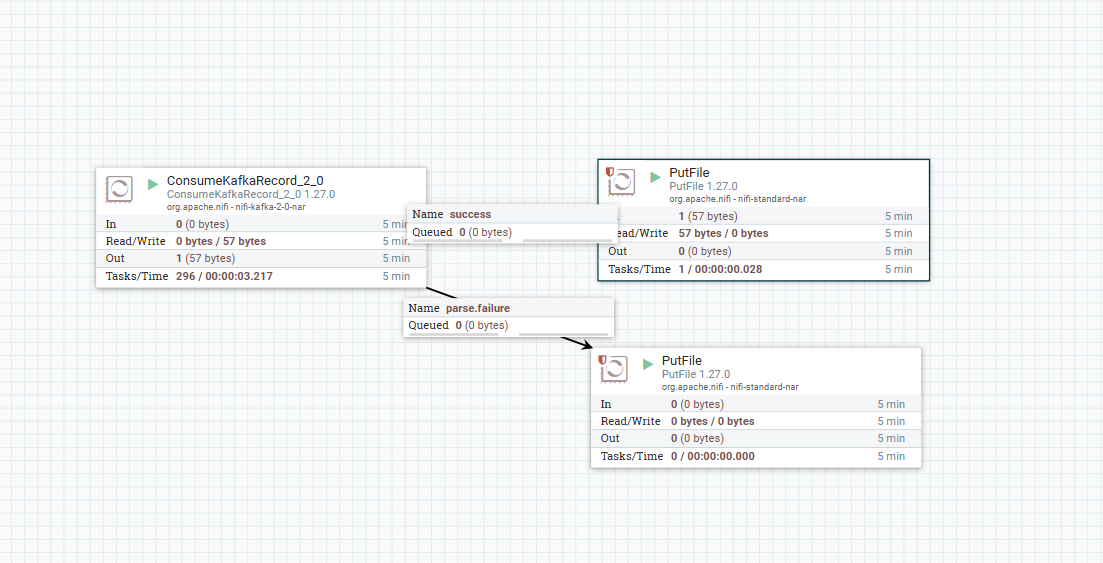

In [40]:
#imagen del flujo
display(Image(filename="cap02.png"))

In [29]:
#mandar mensaje
from kafka import KafkaProducer
import json
p = KafkaProducer(bootstrap_servers='localhost:9092',
                  value_serializer=lambda v: json.dumps(v).encode())
p.send('eventos', {"id":1,"tipo":"ALERTA","valor":900,"destino":"Santiago"})
p.flush()

In [34]:
from kafka import KafkaProducer
import json

p = KafkaProducer(bootstrap_servers='localhost:9092',
                  value_serializer=lambda v: json.dumps(v).encode())

mensaje = {"id": 4, "tipo": "INFO", "valor": 321, "destino": "Santiago"}
p.send('eventos', mensaje)
p.flush()
print("Mensaje enviado")

Mensaje enviado


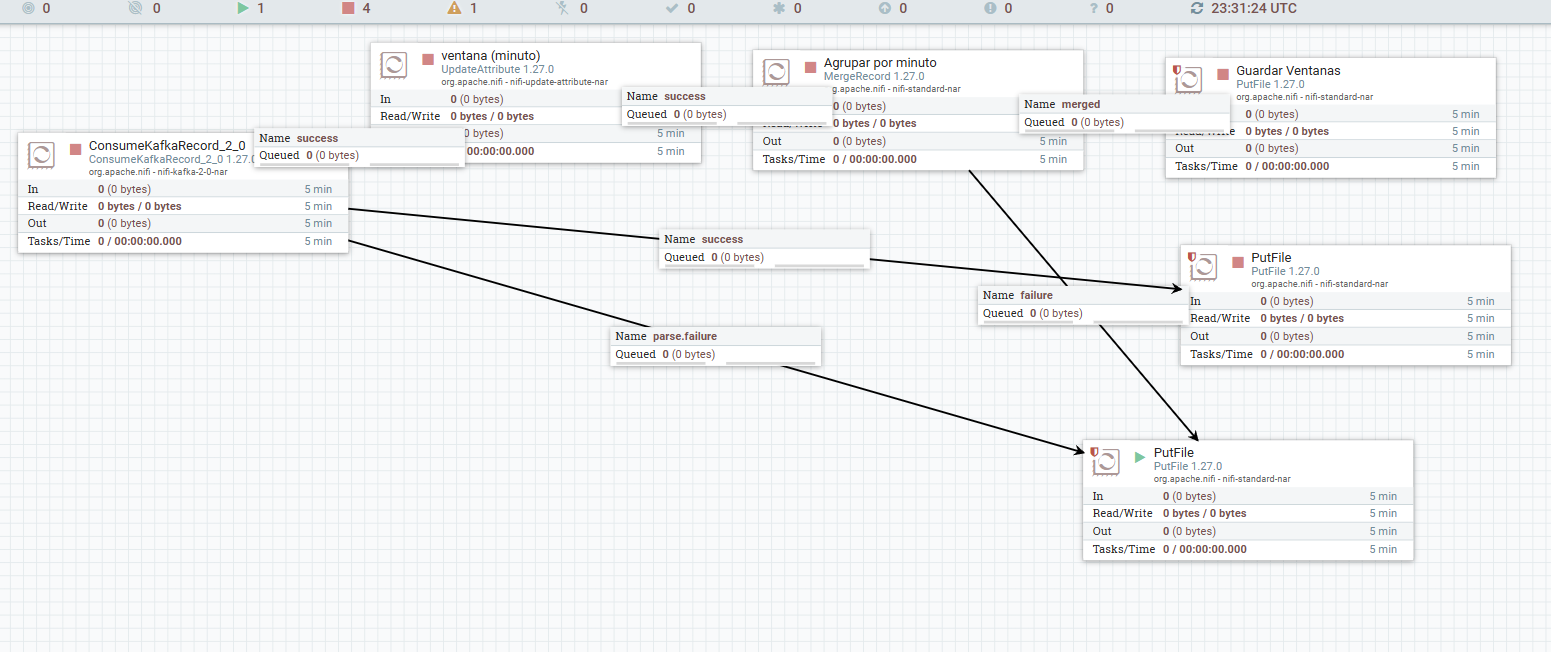

In [41]:
#imagen procesamiento por ventana
display(Image(filename="cap03.png"))

In [37]:
# prueba mensajes 
from kafka import KafkaProducer
import json, time, random
p = KafkaProducer(bootstrap_servers='localhost:9092',
                  value_serializer=lambda v: json.dumps(v).encode())

for i in range(10):
    p.send('eventos', {"id": i, "tipo": random.choice(["INFO","ALERTA","ERROR"]),
                       "valor": random.randint(100,950),
                       "destino": random.choice(["Santiago","Temuco","Concepción","Valparaíso"])})
    p.flush()
    time.sleep(3)

# Leccion 4

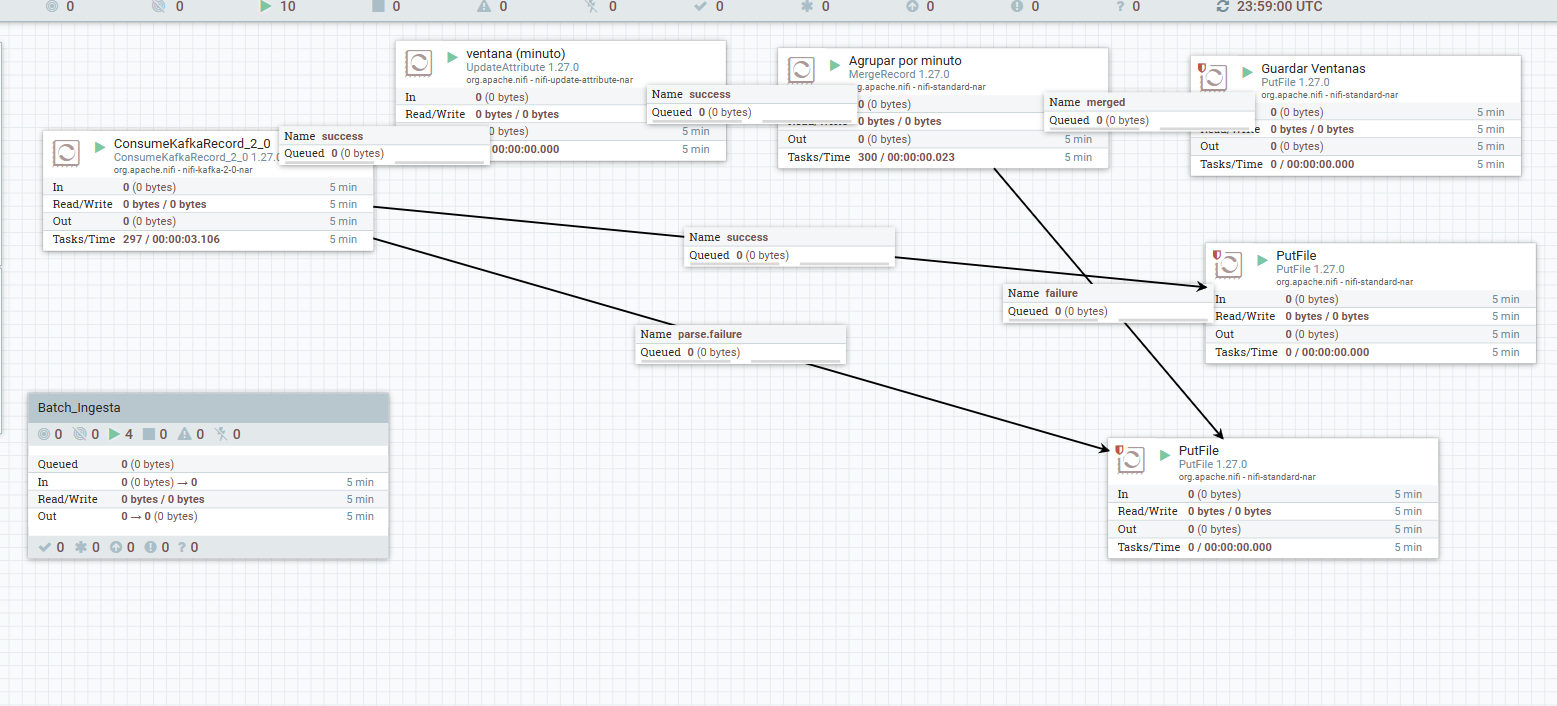

In [42]:
#Flujo integrado
#primer flujo en stream y luego flujo en batch (mas detalles en el siguiente de batch)
display(Image(filename="cap04.png"))

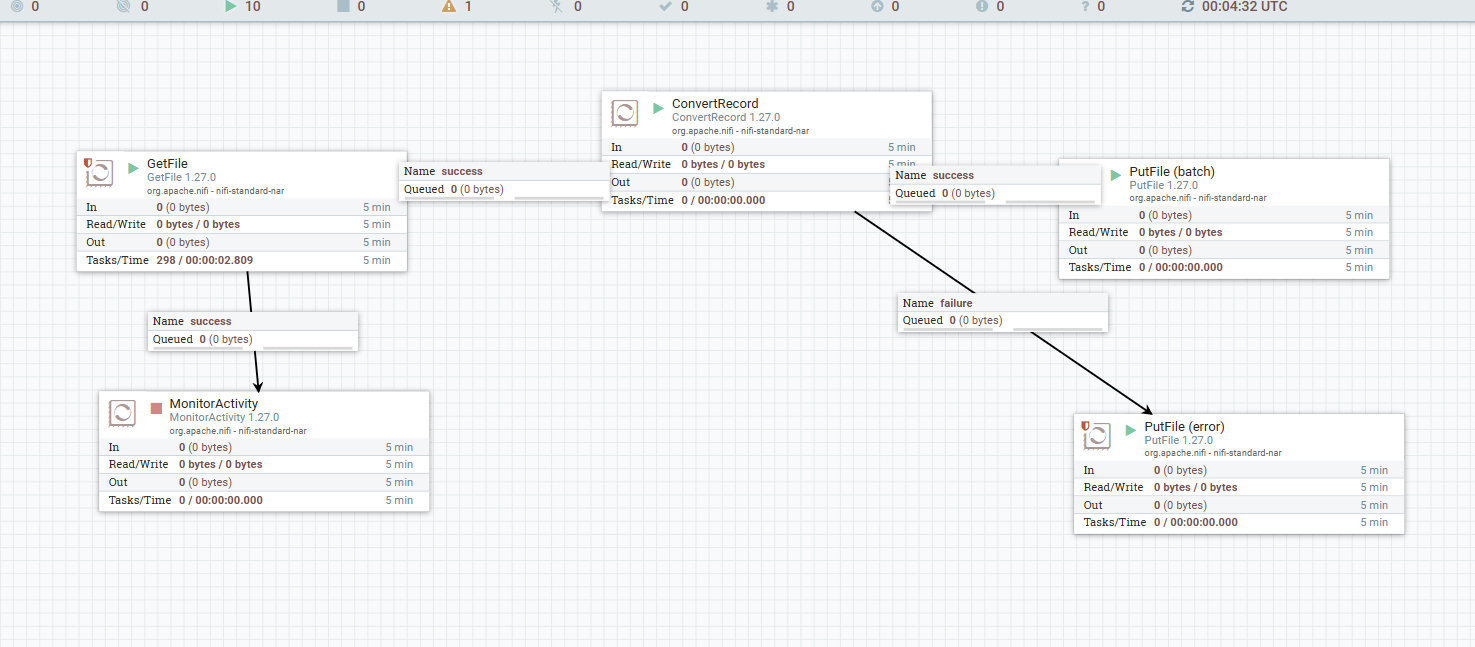

In [43]:
#Flujo con manejo de errores y alertas
display(Image(filename="cap05.png"))

# Evaluación de la solución (NiFi + Kafka)

##  Ventajas
- **Diseño visual y rápido**: flujos sin código extensivo; ideal para iterar y enseñar.
- **Conectores nativos**: Kafka, archivos, DB, APIs → menos “pegamento”.
- **Trazabilidad**: *Data Provenance* y contadores por procesador.
- **Resiliencia**: backpressure, reintentos, rutas `failure` + DLQ → *at-least-once* con Kafka.
- **Parametrización**: *Parameter Contexts* → mismo flujo para dev/qa/prod.
- **Integración unificada**: batch y streaming en una sola plataforma.
- **Despliegue en contenedores**: sencillo con Docker/Compose; escalable a clúster.

##  Desventajas / límites
- **Ventanas/estado** limitados para analítica compleja (mejor Spark/Flink).
- **Versionado/CI** requiere NiFi Registry; no es “git-first”.
- **Alto volumen sostenido**: necesita tuning de repositorios y disco rápido.
- **Infer Schema** cómodo pero frágil → preferible esquemas explícitos en prod.
- **Montajes en Windows/OneDrive** pueden complicar volúmenes (operativo).
- **Operación con muchos flujos** demanda gobernanza y convenciones.
- **Exactly-once** end-to-end no garantizado sin diseño idempotente aguas abajo.

##  Cuándo usar / evitar
**Usar cuando:**
- Necesitas **ingesta/transformación ligera** y time-to-value rápido.
- Quieres **unificar batch y streaming** con monitoreo/alertas sencillos.
- Requieres **trazabilidad** por evento/lote.

**Evitar o complementar cuando:**
- Pides **streaming avanzado** (joins, ventanas deslizantes complejas) → Spark/Flink.
- Requieres **DAGs de orquestación** con dependencias y backfills → Airflow/Prefect.
- Procesamiento analítico/ML a gran escala → Spark/Flink/Beam.

##  Riesgos y mitigaciones
- **Esquemas cambiantes** → usar lectores con **schema fijo/registry**; pruebas de contrato.
- **DLQ creciendo** → *RetryFlowFile* con límite, métricas y playbooks de reproceso.
- **Crecimiento de flujos** → Process Groups, NiFi Registry, naming y revisión de pares.
- **Saturación de repositorios** → dimensionar `content/flowfile/provenance`, monitoreo de I/O.
- **Idempotencia** → claves naturales y *upsert/ON CONFLICT* en DB; deduplicación.

##  Alternativas / complementos
- **Kafka Connect / Debezium**: conectores declarativos y CDC.
- **Spark / Flink**: streaming con ventanas/joins complejos.
- **Airflow / Prefect**: orquestación de jobs/DAGs.
- **DBT**: modelado/transformación en el DWH.

##  Conclusión
Para el alcance del proyecto (ingesta **batch + streaming**, clasificación, **DLQ**, monitoreo y evidencias en disco/DB), **NiFi + Kafka** es **adecuado**: entrega rápida, operable y trazable.  
Si el requerimiento evoluciona a **analítica streaming avanzada** o **DAGs complejos**, incorporar **Spark/Flink** y/o **Airflow** como capas complementarias es el siguiente paso natural.


# Arquitectura final (enfoque modular) — ABP Integración de Datos

## 1) Visión general
La solución integra **ingesta batch y streaming** en **Apache NiFi**, usando **Kafka** para mensajería y archivos/DB como destinos. La arquitectura se organiza en **módulos** (Process Groups) desacoplados, con **servicios y parámetros compartidos**, facilitando mantenimiento, escalado y reutilización.

---

## 2) Módulos (Process Groups) y responsabilidades

- **/Comunes**
  - *Qué contiene:* Controller Services compartidos (JsonTreeReader, JsonRecordSetWriter, CSVReader, DBCP), Parameter Context.
  - *Propósito:* Centralizar config técnica para evitar duplicación.

- **/Streaming_Ingesta**
  - *Flujo:* `ConsumeKafkaRecord_2_0` → (opcional `UpdateAttribute` + `MergeRecord` para ventanas) → `RouteOnAttribute` (reglas) → `PutFile/PutDatabaseRecord`.
  - *Propósito:* Procesar eventos en tiempo real desde Kafka; clasificación y/o ventanas simples.

- **/Batch_Ingesta**
  - *Flujo:* `GetFile` (CSV) → `ConvertRecord` (CSV→JSON) → `ValidateRecord` (opcional) → `PutFile/PutDatabaseRecord`.
  - *Propósito:* Cargas por lote desde archivos (o DB origen) con transformaciones básicas.

- **/Alertas_Monitoreo**
  - *Flujo:* `MonitorActivity` (inactividad) → `ReplaceText` (mensaje) → `PutFile(/data/alerts)` o `PutEmail/InvokeHTTP`.
  - *Propósito:* Señalizar caídas/silencio, enviar alertas y registrar evidencias.

- **/Errores_DLQ**
  - *Flujo:* Ramas `failure`/`parse.failure` → `RetryFlowFile` (reintentos) → `PutFile(/data/dlq)` si se agotan.
  - *Propósito:* Control de errores recuperables/no recuperables.

> **Comunicación entre módulos:** Input/Output Ports (si se encadenan grupos), o conexiones directas dentro de cada PG.  
> **Compartición:** todos los PG usan los mismos Controller Services y parámetros del root.

---

## 3) Interfaces y contratos

- **Entradas**
  - Kafka → *Topic:* `${kafka.topic}` (p. ej. `eventos`).
  - Archivos → *Directorio batch:* `${dir.in.batch}` (CSV con cabecera).
- **Salidas**
  - Archivos → `${dir.out.raw}`, `${dir.out.batch}`, `${dir.out.windows}`.
  - (Opcional) DB → tabla `envios` (via `PutDatabaseRecord`).
- **Errores**
  - `${dir.errors}` (errores de parseo/proceso), `${dir.dlq}` (DLQ definitivo).
- **Esquema**
  - Streaming: JSON (Infer schema o esquema fijo).
  - Batch: CSV con cabecera; convertido a JSON antes de persistir.

---

## 4) Parámetros (Parameter Context)
| Parámetro | Ejemplo |
|---|---|
| `kafka.bootstrap` | `kafka:29092` |
| `kafka.topic` | `eventos` |
| `dir.in.batch` | `/data/in/batch` |
| `dir.out.raw` | `/data/out/raw` |
| `dir.out.batch` | `/data/out/batch` |
| `dir.out.windows` | `/data/out/windows` |
| `dir.errors` | `/data/errors` |
| `dir.alerts` | `/data/alerts` |
| `dir.dlq` | `/data/dlq` |
| `db.url` | `jdbc:postgresql://postgres-demo:5432/demo` |
| `db.user` / `db.pass` | `admin` / `admin` |



---

## 5) Servicios (Controller Services) compartidos
- **JsonTreeReader** — *Schema:* Infer Schema  
- **JsonRecordSetWriter** — *Schema:* Inherit Record Schema  
- **CSVReader** — *Header Line Present:* true, *Schema:* Infer Schema  
- **DBCPConnectionPool** — URL/credenciales por parámetros  
*(Habilitados en root para uso en todos los PG.)*

---

## 6) Operación, errores y monitoreo

- **Backpressure** (en conexiones críticas): `10000` objetos, `512 MB` datos.
- **Reintentos**: `RetryFlowFile` (p. ej. 3 intentos, 30s) antes de DLQ.
- **DLQ**: `/data/dlq` para análisis y reproceso manual.
- **Monitoreo**: `MonitorActivity` en Batch y Streaming (`inactive/stopped` → alerta).
- **Alertas**: `PutFile(/data/alerts)` (evidencia) o `PutEmail`/`InvokeHTTP` (webhook).
- **Trazabilidad**: Data Provenance y Counters por procesador.

---

## 7) Despliegue (Docker/Compose) y rutas
- Volumen NiFi: `"<ruta local>/data:/data"`  
- Carpetas necesarias en el host:  
  `/data/in/batch`, `/data/out/batch`, `/data/out/raw`, `/data/out/windows`, `/data/errors`, `/data/alerts`, `/data/dlq`  
- Servicios: `zookeeper`, `kafka`, `nifi`, `kafka-ui`, (opcional `postgres`).

---

## 8) Escalabilidad y seguridad (base)
- **Escalado**: NiFi en clúster (varios nodos) y Kafka particionado; aumentar `Concurrent tasks` y ajustar repositorios (content/flowfile/provenance).
- **Seguridad**: credenciales vía parámetros/secret manager, TLS en Kafka/NiFi (si aplica), control de acceso por PG (NiFi users/policies).

---

